<a href="https://colab.research.google.com/github/Satyake/Triplet-Loss_Siamese_NN/blob/master/Triplet-Loss-Siamese_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.pyplot as plt
import random
from pca_plotter import PCAPlotter
import tensorflow as tf

In [2]:
from mnist import MNIST
%matplotlib notebook

mndata = MNIST('/home/satyake/Downloads/weatherman')
mndata.gz=True

x_train, y_train = mndata.load_training()
# or
mndata1=MNIST('/home/satyake/Downloads/weatherman')
mndata1.gz=True
x_test,y_test=mndata1.load_testing()
y_train=np.array(y_train)
y_test=np.array(y_test)

ModuleNotFoundError: ignored

In [2]:
import numpy as np 

In [3]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
x_test.shape

(10000, 28, 28)

In [6]:
x_train=np.reshape(x_train,(60000,784))/255.
x_test=np.reshape(x_test,(10000,784))/255.

10000

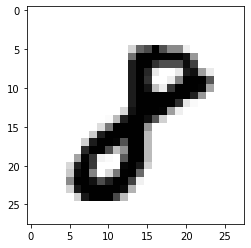

In [7]:
plt.imshow(np.reshape(x_train[31],(28,28)),cmap='binary')
len(x_test)

In [8]:
def plot_triplet(data):
    plt.figure(figsize=(6,3))
    for i in range(0,3):
        plt.subplot(1,3,i+1)
        plt.imshow(np.reshape(data[i],(28,28)),cmap='gray')
    plt.show()

def create_batch(batch_size):
    anchors=np.zeros((batch_size,784))
    positives=np.zeros((batch_size,784))
    negatives=np.zeros((batch_size,784))
    
    for i in range(0,batch_size):
            index=random.randint(0,len(x_train)-1)
            anc=x_train[index]
            label_of_anc=y_train[index]
            indices_of_pos=np.squeeze(np.where(y_train==label_of_anc))
            indices_of_neg=np.squeeze(np.where(y_train!=label_of_anc))
            #print(indices_of_pos)
            pos=x_train[indices_of_pos[random.randint(0,len(indices_of_pos)-1)]]
            neg=x_train[indices_of_neg[random.randint(0,len(indices_of_neg)-1)]]
            positives[i]=pos
            negatives[i]=neg
            anchors[i]=anc
    return [anchors,positives,negatives]
    

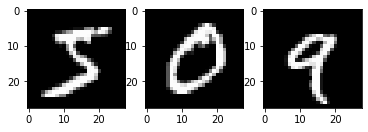

In [9]:
plot_triplet([x_train[0],x_train[1],x_train[4]])  #testing the triplet plot


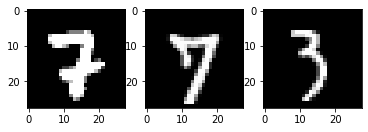

In [10]:
files=create_batch(1)
plot_triplet(files) #CHECKING THE BATCHGEN FUNCTION

In [11]:
emb_dim=512
embedding_model=tf.keras.Sequential([tf.keras.layers.Dense(64,activation='relu',input_shape=(784,)),
                                     tf.keras.layers.Dense(512,activation='sigmoid')])

in_anc=tf.keras.layers.Input(shape=(784,))
in_pos=tf.keras.layers.Input(shape=(784,))
in_neg=tf.keras.layers.Input(shape=(784,))
emb_anc=embedding_model(in_anc) #apply the model to the anchor,positive and negatives
emb_pos=embedding_model(in_pos)
emb_neg=embedding_model(in_neg)
out=tf.keras.layers.concatenate([emb_anc,emb_pos,emb_neg],axis=1)
Network=tf.keras.models.Model([in_anc,in_pos,in_neg],out)

In [12]:
embedding_model.summary() #to view the complete model
Network.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 512)               33280     
                                                                 
Total params: 83,520
Trainable params: 83,520
Non-trainable params: 0
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(Non

In [13]:
sample_embedding = embedding_model.predict(np.expand_dims(x_train[1],axis=0))[0]

In [14]:
def data_generator(batch_size,emb_dim):
    while True:
        x=create_batch(batch_size)
        y=np.zeros((batch_size,3*emb_dim))
        yield x,y
        

In [15]:
def loss(y_true,y_pred):
        anc=y_pred[:,:emb_dim]
        pos=y_pred[:,emb_dim:2*emb_dim]
        neg=y_pred[:,2*emb_dim:]
        dp=tf.reduce_mean(tf.square(anc-pos),axis=1)
        dn=tf.reduce_mean(tf.square(anc-neg),axis=1)
        return tf.maximum(dp-dn+0.9,0.)

In [19]:
batch_size=1024
epochs=10
steps_per_epoch=2
Network.compile(loss=loss,optimizer='rmsprop')
X,Y=x_test[:1000],y_test[:1000]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


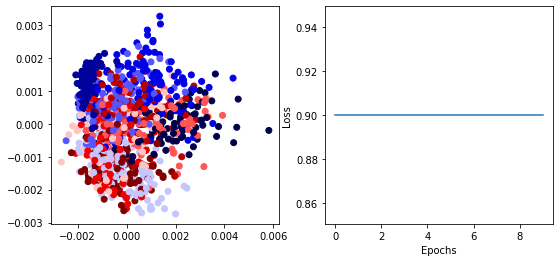

In [20]:
_ = Network.fit_generator(
    data_generator(batch_size,emb_dim),
    steps_per_epoch=15,
    epochs=epochs, verbose=False,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            X, Y
        )]
)
#we visualize the seperation on the test_set after training

In [ ]:
Network.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=60, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)